# 전체적인 로직
1. Module Import
2. Set Device
3. Set Hyper Parameters
  1. input_size, 
  2. hidden_size,
  3. num_classes, 
  4. num_epochs, 
  5. batch_size, 
  6. learning_rate

4. DownLoad and Save data
5. Make Loader from save data
6. Make NN Class with Forward function
7. Generate Model, lossfunction, optimization
8. Learn the model, override weights and bias values
9. Test Model

#1. Import Modules

In [50]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

#2. Set Device

In [51]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu') 
device

device(type='cuda')

#3. Set Hyper Parameters

In [52]:
input_size = 7 # 들어갈 특징의 갯수
hidden_size = 256 # 중간(히든레이어)의 예측(출력)값이 hidden_size가 된다. 즉 train데이터의 사이즈를 알아봐서 설정하면 된다.
num_classes = 2 # 0 아니면 1의 예측값만 얻어 낼 것으로 2로 선언한다.
num_epochs = 1000
learning_rate = 0.01

#4. Download and Save datas

##### local data를 가져옴

In [53]:
from google.colab import files # local에서 데이터를 가져오는 Module이다. 

uploaded_train = files.upload() # 이 files.upload()를 실행하면 파일을 선택창이 나오는데 선택해서 데이터를 넣어줄 수 있다.
uploaded_test = files.upload()

Saving titanic_train.csv to titanic_train (1).csv


Saving titanic_test.csv to titanic_test (1).csv


##### 가져온 데이터의 데이터셋을 바꿔준다.

In [54]:
import io
train = pd.read_csv(io.BytesIO(uploaded_train['titanic_train.csv'])) # uploaded_train데이터 셋을  Pandas Dataframe 형태로 저장한다.
test = pd.read_csv(io.BytesIO(uploaded_test['titanic_test.csv']))

In [55]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [57]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


  위 결과물들을 종합적으로 보면 
  test데이터에는 Survived 특성이 없는걸로 보아 해당 컬럼을 예측해야한다는 것을 알 수 있다.  
  즉, 학습할때 train의 Survived의 값을 y로 지정해서 학습을 진행하면 된다.  
  그리고 train 과 test의 데이터의 크기가 891, 418이라는것을 염두하고 작업을 진행하자.

### Data Preprocessing

In [58]:
train_test_data= [train, test] 
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

title_mapping = {"Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", 
                 "Master": "etc", "Dr": "etc", "Rev": "etc", "Col": "etc", "Major": "etc", "Mlle": "etc","Countess": "etc",
                 "Ms": "etc", "Lady": "etc", "Jonkheer": "etc", "Don": "etc", "Dona" : "etc", "Mme": "etc","Capt": "etc","Sir": "etc" }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [59]:
train["FamilySize"] = train["SibSp"] + train["Parch"]
test["FamilySize"] = test["SibSp"] + test["Parch"]
train.drop('SibSp', axis=1, inplace=True)
train.drop('Parch', axis=1, inplace=True)
test.drop('SibSp', axis=1, inplace=True)
test.drop('Parch', axis=1, inplace=True)

In [60]:
# 트레이닝 자료에서 삭제한것은 테스트도 삭제해야한다.
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True) 

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

test_PassengerId=test["PassengerId"]
train.drop('PassengerId', axis = 1, inplace=True)
test.drop('PassengerId', axis = 1, inplace=True)

In [61]:
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

In [62]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

#### Binning

In [63]:
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 24), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 32), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 42), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 42) & (dataset['Age'] <= 47), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 47) & (dataset['Age'] <= 56), 'Age'] = 5
    dataset.loc[ dataset['Age'] > 56, 'Age'] = 6

In [64]:
for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 9, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 9) & (dataset['Fare'] <= 20), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 20) & (dataset['Fare'] <= 30), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 40), 'Fare'] = 3
    dataset.loc[ dataset['Fare'] > 40, 'Fare'] = 4

####Encoding

In [65]:
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [66]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [67]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "etc": 3}
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [68]:
# Redefine

train_data = train.drop('Survived', axis=1)
train_label = train['Survived']
print(train_data)
print(train_label)

     Pclass  Sex  Age  Fare  Embarked  Title  FamilySize
0         3    0  1.0   0.0         0      0           1
1         1    1  3.0   4.0         1      2           1
2         3    1  2.0   0.0         0      1           0
3         1    1  3.0   4.0         0      2           1
4         3    0  3.0   0.0         0      0           0
..      ...  ...  ...   ...       ...    ...         ...
886       2    0  2.0   1.0         0      3           0
887       1    1  1.0   2.0         0      1           0
888       3    1  1.0   2.0         0      1           3
889       1    0  2.0   2.0         1      0           0
890       3    0  2.0   0.0         2      0           0

[891 rows x 7 columns]
0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


In [69]:
train_data

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,0,1.0,0.0,0,0,1
1,1,1,3.0,4.0,1,2,1
2,3,1,2.0,0.0,0,1,0
3,1,1,3.0,4.0,0,2,1
4,3,0,3.0,0.0,0,0,0
...,...,...,...,...,...,...,...
886,2,0,2.0,1.0,0,3,0
887,1,1,1.0,2.0,0,1,0
888,3,1,1.0,2.0,0,1,3
889,1,0,2.0,2.0,1,0,0


In [70]:
train_label

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [71]:
train

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,0,1.0,0.0,0,0,1
1,1,1,1,3.0,4.0,1,2,1
2,1,3,1,2.0,0.0,0,1,0
3,1,1,1,3.0,4.0,0,2,1
4,0,3,0,3.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...
886,0,2,0,2.0,1.0,0,3,0
887,1,1,1,1.0,2.0,0,1,0
888,0,3,1,1.0,2.0,0,1,3
889,1,1,0,2.0,2.0,1,0,0


#5. Make Loader from save datas


In [72]:
# DataLoader는 C++로 코딩되어있음...
train_loader = torch.utils.data.DataLoader(dataset = train, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test, shuffle=False)

In [73]:
X = train_loader.dataset.drop(columns='Survived')
target = train_loader.dataset['Survived']

In [74]:
X

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,3,0,1.0,0.0,0,0,1
1,1,1,3.0,4.0,1,2,1
2,3,1,2.0,0.0,0,1,0
3,1,1,3.0,4.0,0,2,1
4,3,0,3.0,0.0,0,0,0
...,...,...,...,...,...,...,...
886,2,0,2.0,1.0,0,3,0
887,1,1,1.0,2.0,0,1,0
888,3,1,1.0,2.0,0,1,3
889,1,0,2.0,2.0,1,0,0


In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, shuffle=True)

In [77]:
X_train = X_train.values.tolist()

In [78]:
X_test = X_test.values.tolist()

In [79]:
y_test = y_test.values.tolist()

In [80]:
X_train

[[3.0, 1.0, 3.0, 3.0, 0.0, 2.0, 6.0],
 [1.0, 0.0, 0.0, 4.0, 0.0, 3.0, 3.0],
 [3.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0],
 [1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 0.0],
 [1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0],
 [2.0, 0.0, 3.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 3.0, 4.0, 0.0, 0.0, 3.0],
 [1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0],
 [2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0],
 [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
 [3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
 [3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0],
 [2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 1.0],
 [1.0, 0.0, 6.0, 3.0, 0.0, 0.0, 0.0],
 [2.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 3.0, 4.0, 0.0, 2.0, 1.0],
 [1.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0],
 [3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0],
 [3.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0],
 [2.0, 0.0, 5.0, 1.0, 0.0, 0.0, 0.0],
 [2.0, 1.0, 1.0, 2.0, 0.0, 2.0, 1.0],
 [3.0, 1.0, 0.0, 3.0, 0.0, 1.0, 6.0],
 [1.0, 0.0, 1.0, 4.0, 0.0, 0.0, 5.0],
 [3.0, 0.0, 0.0, 2.0, 0.0, 3.0, 4.0],
 [3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 5.0, 4.0, 1.0, 2.0, 1.0],
 [3.0, 0.0, 

In [81]:
y_train

610    0
802    1
855    1
310    1
822    0
      ..
623    0
348    1
330    1
301    1
849    1
Name: Survived, Length: 712, dtype: int64

In [82]:
X_train = torch.FloatTensor(X_train) 
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [83]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

tensor([[3., 1., 3.,  ..., 0., 2., 6.],
        [1., 0., 0.,  ..., 0., 3., 3.],
        [3., 1., 1.,  ..., 0., 2., 1.],
        ...,
        [3., 1., 1.,  ..., 2., 1., 2.],
        [3., 0., 2.,  ..., 2., 0., 2.],
        [1., 1., 3.,  ..., 1., 2., 1.]])
tensor([[3., 0., 3.,  ..., 1., 0., 0.],
        [1., 0., 2.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 3., 0.],
        ...,
        [3., 0., 2.,  ..., 0., 0., 2.],
        [3., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 2.,  ..., 0., 1., 0.]])
tensor([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1

#6. Make NN class with Forward Function

In [84]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet,self).__init__()
    self.net = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,num_classes)
    )
  def forward(self, x):
    return self.net(x)

#7. Generate Model, loss_function, optimizer

In [85]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device) # (특성갯수, 히든레이어 갯수, 라벨 갯수)
loss_function = nn.CrossEntropyLoss() # 여기안에 softmax(), -log(x), R(x)가 내장되어있다. 바로 모델의 loss값을 알수 있다.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam을 사용해서 테스트를 진행. parameters로 모델의 w, b를 알 수 있다.

#8. Learn Model 

In [86]:
total_step = len(X_train)
total_step

712

In [87]:
import numpy as np

In [88]:
X_train = np.array(X_train)

In [89]:
X_train

array([[3., 1., 3., ..., 0., 2., 6.],
       [1., 0., 0., ..., 0., 3., 3.],
       [3., 1., 1., ..., 0., 2., 1.],
       ...,
       [3., 1., 1., ..., 2., 1., 2.],
       [3., 0., 2., ..., 2., 0., 2.],
       [1., 1., 3., ..., 1., 2., 1.]], dtype=float32)

In [90]:
X_train = torch.from_numpy(X_train)

In [91]:
X_train

tensor([[3., 1., 3.,  ..., 0., 2., 6.],
        [1., 0., 0.,  ..., 0., 3., 3.],
        [3., 1., 1.,  ..., 0., 2., 1.],
        ...,
        [3., 1., 1.,  ..., 2., 1., 2.],
        [3., 0., 2.,  ..., 2., 0., 2.],
        [1., 1., 3.,  ..., 1., 2., 1.]])

In [92]:
collect = 0
total = 0
loss_list = []
for epoch in range(num_epochs):

    # 2. 100개의 image를 모델에 넣어서 output 변수로 prediction(예측값)값을 가져온다.
    outputs = model(X_train.to(device))

    # 3, loss_function에 넣어서 모델의 사진 마다의 loss값을 추출한다.
    loss = loss_function(outputs, y_train.to(device)) # batch_size가 100개에 대한 loss값 100개 가 나온다.
    
    # 4. optimizer을 사용하기위하여 초기화를 시켜준다. 또한 위에 선언된 Adam방법을 가지고 계산을 시작할 준비를 한다.
    optimizer.zero_grad()

    # 5. loss위 3번에서 추출된 loss값을 back Propagation으로 W값과 bias값을 재 선언해준다.
    loss.backward() # backward 함수는 autograd 를 사용하여 자동으로 정의된다.

    # 6. 위의 5번에서 재선언된 loss값을 가지고 step을 밟아 경사하강을 진행한다. 즉, Adam Gradient descent의 연산으로 경사하강한다.
    optimizer.step() # 재선언된 W와 b를 매개변수로 받고 있으므로, 위의 5번에서 재 선언된 w와 b를 가지고 연산해서 하강하게된다.

    loss_list.append(loss.item())
    
    # 7. loss값을 잘 알아보기 위해서 epoch마다 print해본다. 
    if (epoch+1)% 100 == 0:
      # print(loss.item())
      print(f'[{epoch+1}/{num_epochs}], Step[{epoch+1}/{total_step}], Loss[{loss.item():.4f}]')


[100/1000], Step[100/712], Loss[0.3319]
[200/1000], Step[200/712], Loss[0.2915]
[300/1000], Step[300/712], Loss[0.2665]
[400/1000], Step[400/712], Loss[0.2479]
[500/1000], Step[500/712], Loss[0.2364]
[600/1000], Step[600/712], Loss[0.2326]
[700/1000], Step[700/712], Loss[0.2293]
[800/1000], Step[800/712], Loss[0.2284]
[900/1000], Step[900/712], Loss[0.2252]
[1000/1000], Step[1000/712], Loss[0.2235]


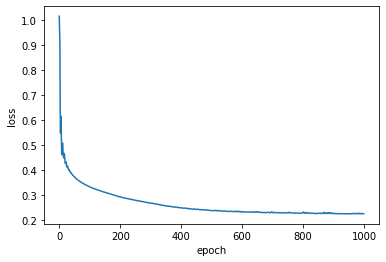

In [93]:
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#9. Test Model

In [107]:
with torch.no_grad(): 
    # Write Code!!   
    
    out = model(X_test.to(device))
    
    _, pred = torch.max(out,1)
    score = sum(pred == y_test.to(device)).item() # item()은 값이 하나 일때만 가능하다.
    print('예측값, 정답 출력')
    for i in range(len(y_test)):
        print(f'{i}) {y_test[i]},{pred[i]}')
        
    print(f'{len(y_test)}개의 Test 데이타 중에서 정답을 맞춘 갯수는 {score} 개 입니다!!')
    print(f'{round(score/len(y_test),3)*100}%')

예측값, 정답 출력
0) 0,0
1) 1,1
2) 0,1
3) 1,0
4) 1,1
5) 0,1
6) 0,0
7) 0,1
8) 1,1
9) 0,0
10) 0,0
11) 0,0
12) 0,0
13) 1,1
14) 1,1
15) 1,0
16) 0,0
17) 1,1
18) 0,1
19) 1,0
20) 1,1
21) 1,1
22) 1,1
23) 1,1
24) 0,0
25) 1,1
26) 1,0
27) 1,1
28) 0,0
29) 0,0
179개의 Test 데이타 중에서 정답을 맞춘 갯수는 140 개 입니다!!
78.2%
